In [1]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

/Users/mustafamuratarat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

First, let's create the moons dataset using Scikit-Learn's make_moons() function:

In [3]:
from  sklearn.datasets  import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

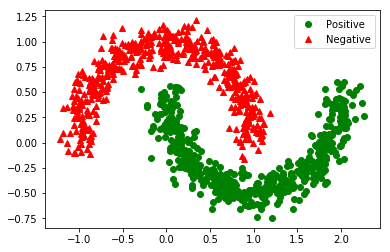

In [4]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

We must not forget to add an extra bias feature ($x_0 = 1$) to every instance. For this, we just need to add a column full of 1s on the left of the input matrix $\mathbf{X}$

In [5]:
inputs = np.c_[np.ones((m,1)), X_moons]
output = y_moons

In [8]:
inputs[:5,]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

output is a 1D array but we need to reshape it to a column vector 

In [10]:
output=output.reshape(-1,1)

Now let's split the data into a training set and a test set:

In [15]:
def train_test_split(X, y, test_ratio):
    n = X.shape[0]
    test_size = int(n * test_ratio)
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(inputs, output, 0.2)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 3)
(200, 3)
(800, 1)
(200, 1)


In [36]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [37]:
X_batch,y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  0.3214734 , -0.17588868],
       [ 1.        ,  1.07322989,  0.4288086 ],
       [ 1.        ,  0.95683572, -0.50135736],
       [ 1.        , -0.23000106,  0.97089647],
       [ 1.        ,  1.37518228, -0.3707726 ]])

In [38]:
reset_graph()

In [42]:
n_inputs = X_train.shape[1] -1 
X = tf.placeholder(tf.float32, shape=[None, n_inputs+1], name = "x")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform(shape= [n_inputs + 1, 1], minval = -1.0, maxval=1.0), name = "theta")
logits = tf.matmul(X, theta, name="logits")
#predictions = 1/(1+ tf.exp(-logits))
predictions = tf.sigmoid(logits)

#the log loss is a good cost function to use for Logistic Regression
#$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$
#one can use TensorFlow's tf.losses.log_loss() function

loss = tf.losses.log_loss(labels = y, predictions = predictions, weights=1.0, epsilon=1e-07) # uses epsilon = 1e-7 by default
#OR one can implement it oneself:
#epsilon = 1e-7  # to avoid an overflow when computing the log
#loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            
    predictions_val = predictions.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.8044542
Epoch: 100 	Loss: 0.35207424
Epoch: 200 	Loss: 0.31111053
Epoch: 300 	Loss: 0.294529
Epoch: 400 	Loss: 0.28592446
Epoch: 500 	Loss: 0.28132707
Epoch: 600 	Loss: 0.278829
Epoch: 700 	Loss: 0.276567
Epoch: 800 	Loss: 0.27578127
Epoch: 900 	Loss: 0.27473757


To classify each instance, we can go for maximum likelihood: classify as positive any instance whose estimated probability is greater or equal to 0.5:

In [43]:
y_pred  = ( predictions_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True]])

Depending on the use case, you may want to choose a different threshold than 0.5: make it higher if you want high precision (but lower recall), and make it lower if you want high recall (but lower precision).

In [44]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.8613861386138614

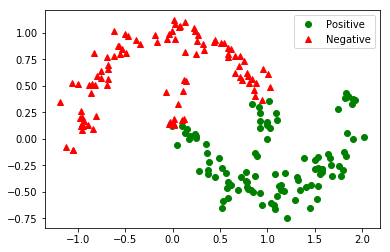

In [45]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()